In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
# This is added to ignore DeprecationWarning: np.asscalar(a)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Note of the source of the codes: 
Most of the codes are modified from previous practicalMixGauss notebooks. The modifications I made will be mentioned at the beginning of the code.

# Part A: Load data

In [3]:
# Load the apple images and normalize them 
# reduce the image size to shorten the training time
downsize_num = 3

files = glob.glob("apples/*.jpg")
ColorImgs = []
for myFile in files:
    im = Image.open(myFile)
    col, rows = im.size
    im = im.resize((round(col/downsize_num), round(rows/downsize_num)), Image.ANTIALIAS)
    im = np.array(im)/255
    ColorImgs.append(im)


In [4]:
# Load the apple masks, round the masks to get binary values 
maskfiles = glob.glob("apples/*.png")
MaskImgs = []
for myFile in maskfiles:
    im = Image.open(myFile)
    col, rows = im.size
    im = im.resize((round(col/downsize_num), round(rows/downsize_num)), Image.ANTIALIAS)
    im = np.round(np.array(im)[:,:,1])
    im = np.array(im)/255
    MaskImgs.append(im)


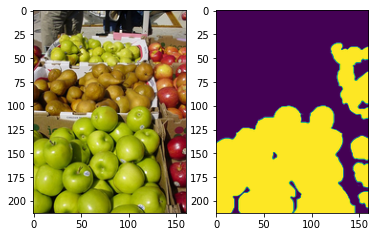

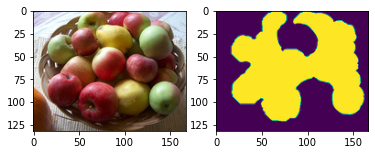

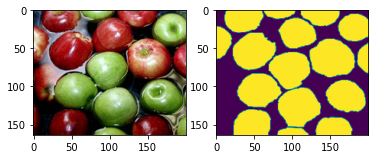

In [5]:
# Plot the images and the mask to check if loaded correctly
for i in range(len(ColorImgs)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(ColorImgs[i])
    ax2.imshow(MaskImgs[i])

## Comments 1
Comfirmed that the apple images and the masks are loaded correctly.

# Part B: Mixtures of Gaussians

In [6]:
# go through all elements in list, seperate the apples and not-apples
# print each shapes just to double check the numbers make sense
apple = []
notapple = []

for img in range(len(ColorImgs)):
    for row in range(MaskImgs[img].shape[0]):
        for column in range(MaskImgs[img].shape[1]):
            if(MaskImgs[img][row, column] == 1):
                apple.append(ColorImgs[img][row, column, :])
            else:
                notapple.append(ColorImgs[img][row, column, :])
            
apple = np.array(apple).T  
notapple = np.array(notapple).T 
print(apple.shape, notapple.shape)

(3, 41972) (3, 46952)


Now these RGB values are labeled as apple/notapple

In [15]:
# Modified from practicalMixGaussA + practicalMixGaussC
# Only a few modification made to fit the different data dimentions 

#the goal of this routine is to evaluate a Gaussian likelihood
def calcGaussianProb(data,gaussMean,gaussCov):
    """
    Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and 
    gaussCov.
    
    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    gaussMean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    gaussCov -- d by d matrix containing the covariance parameters of the Gaussian distribution.
    
    Returns: 
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by gaussMean and gaussCov.
    """

    nDim = len(data)

    const = np.double(1/np.power(np.power(2*np.pi, nDim)*np.linalg.det(gaussCov), 0.5))
    data_gaussmean = data - gaussMean
    exp_part = np.exp(-0.5 * (data_gaussmean).T @ np.linalg.inv(gaussCov) @ (data_gaussmean))
    like_data = const * exp_part
    
    return like_data

In [56]:
# Modified from practicalMixGaussC
# Not much changed, delete unneeded part to save computing time
# Iteration number can now be controlled by the user

def fitMixGauss(data, k, nIter):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape


    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        


    print("Start")
    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================


        for cData in range(nData):

            curdata = data[:, cData]
            E_numerator = np.zeros((mixGaussEst['k'],1))
            # Calculate for all data points
            for i in range(mixGaussEst['k']):
                like_data = calcGaussianProb(curdata, mixGaussEst['mean'][:,i], mixGaussEst['cov'][:,:,i])
                
                E_numerator[i] = mixGaussEst['weight'][i] * like_data

            postHidden[:, cData] = (E_numerator/np.sum(E_numerator)).reshape(len(E_numerator),)

            

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # TO DO :  Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:
            lambda_numerator = np.sum(postHidden[cGauss, :])
            lambda_denominator = np.sum(postHidden)
            mixGaussEst['weight'][cGauss] = lambda_numerator/lambda_denominator
            
            
            # TO DO :  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            mu_numerator = postHidden[cGauss, :].reshape(1,len(postHidden[cGauss, :])) @ data.T
            mu_denominator = lambda_numerator
            mixGaussEst['mean'][:,cGauss] = mu_numerator/mu_denominator
            
            
            # TO DO :  Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            sigma_numerator = 0
            for i in range(nData):
                # diff has to be reshape for calculating sigma_numerator
                diff = data[:, i].reshape(3,1) - mixGaussEst['mean'][:,cGauss].reshape(3,1)
                sigma_numerator += postHidden[cGauss, i] * diff @ diff.T

            sigma_denominator = lambda_numerator

            mixGaussEst['cov'][:,:,cGauss] = sigma_numerator/sigma_denominator
        
        if (cIter+1) %10 == 0:
            print("Finish iteration ", cIter+1)


    return mixGaussEst

In [253]:
# Modified from practicalMixGaussC (almost the same)
# resizing the image decreases the training time from over 40 mins to under 5 mins
# Note that very unlikely we might get singular matrix, just rerun it and should work 

# number of components, more comments below
apple_nGaussEst = 3
notapple_nGaussEst = 4

nIter = 40


apple_mixGaussEst = fitMixGauss(apple,apple_nGaussEst, nIter);
notapple_mixGaussEst = fitMixGauss(notapple,notapple_nGaussEst, nIter);

Start
Finish iteration  10
Finish iteration  20
Finish iteration  30
Finish iteration  40
Start
Finish iteration  10
Finish iteration  20
Finish iteration  30
Finish iteration  40


## Comments 2
Different (apple_nGaussEst, notapple_nGaussEst, nIter) pairs give different results, and there is no "best combination", there is only trade-offs. For example, one combination might perform really well at telling "red" apples, but it would probably perform really bad at telling "green" apples. After going through over 10 different combinations (apple_nGaussEst range from 3-6, notapple_nGaussEst range from 3-6, nIter range from 30-50), we choose to stay with (apple_nGaussEst = 3, notapple_nGaussEst = 4, nIter = 40) because it performs fairly good on telling apples from various colors and seperate the background really well (execpt for green leaf background, but all combinations perform quite bad on that one). The value of notapple_nGaussEst is slightly higher than apple_nGaussEst because the background is slightly more complicated than apples, so a higher number of GaussEst is used. Also, too many iterations might worsen the performance. It is observed that very higher iterations start to overfit to the color red-brown, so the brown tables in the background start to be predicted as apples. 

# Part C: Posterior probability of being apple

In [267]:
# Load the test images

files = glob.glob("testApples/*.jpg")
TestImgs = []
for myFile in files:
    im = Image.open(myFile)
    col, rows = im.size
    im = im.resize((round(col/downsize_num), round(rows/downsize_num)), Image.ANTIALIAS)
    im = np.array(im)/255
    TestImgs.append(im)

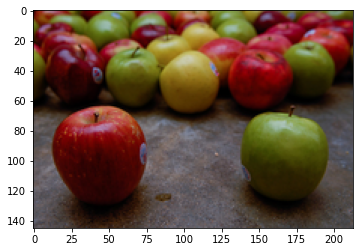

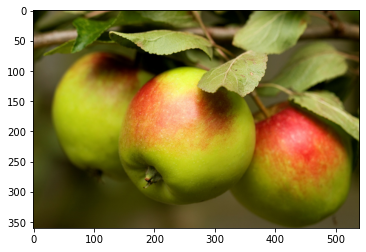

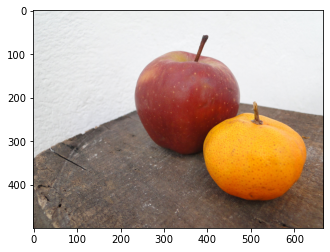

In [268]:
# display the images to confirm that they are correctly loaded
for i in range(len(TestImgs)):
    f, (ax) = plt.subplots()
    ax.imshow(TestImgs[i])


In [269]:
# Modified from practicalMixGaussB
# Previously it was getMixGaussLogLike. Now simply need getMixGaussLike 

# def getMixGaussLogLike(data, mixGaussEst):
def getMixGaussLike(data, mixGaussEst):
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
                                                                              
    # run through each data item

    likelihood = np.zeros([1, nData])
    
    for cData in range(nData):                                                                         
        thisData = data[:, cData]    

        like = 0
        
        for i in range (mixGaussEst['k']):

            like_data = calcGaussianProb(thisData, mixGaussEst['mean'][:,i], mixGaussEst['cov'][:,:,i])

            like += mixGaussEst['weight'][i] * like_data

        likelihood[cData, :] = like
                                                          
                                                                                                       
    return  likelihood

In [270]:
# Modified from practicalMixGaussA
# prior is modified
# evaluation of the images is turn into a loop to deal with multiple images


def eval_apple(TestImgs, prior_apple):
    prior_notapple = 1 - prior_apple

    store_posteriorApple = []

    for image in range(len(TestImgs)):
        print("dealing image ", image)
        im = TestImgs[image]
        imY, imX, imZ = im.shape

        posteriorApple = np.zeros([imY, imX])

        for cY in range(imY): 
            for cX in range(imX):
                #extract this pixel's data
                thisPixelData = np.double(im[cY,cX,:])
                thisPixelData = thisPixelData[:, np.newaxis]
                            
                likeApple = getMixGaussLike(thisPixelData, apple_mixGaussEst)
                likeNotapple = getMixGaussLike(thisPixelData, notapple_mixGaussEst)
                
                #TO DO (c):  calculate posterior probability from likelihoods and 
                #priors using BAYES rule. Replace this: 
                ''' posterior = likelihood * prior / evidence '''
                posteriorApple[cY,cX] = likeApple*prior_apple / (likeApple*prior_apple + likeNotapple*prior_notapple)

        store_posteriorApple.append(posteriorApple)
    
    return store_posteriorApple


dealing image  0
dealing image  1
dealing image  2


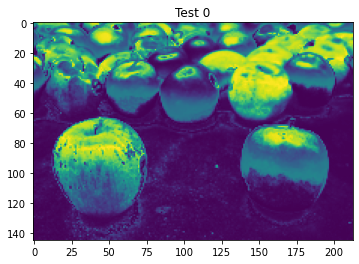

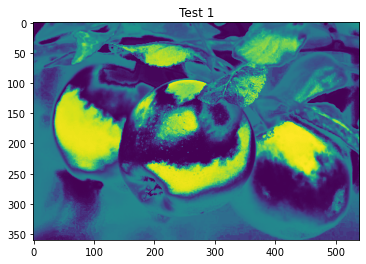

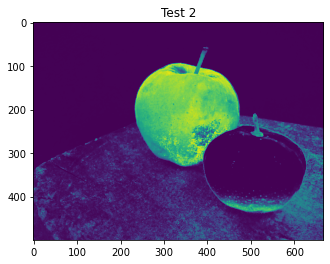

In [271]:
# We can calculate the prior of apple from the 3 initial apple images
nApple = apple.shape[1]
nNotapple = notapple.shape[1]

prior_apple = nApple/(nApple+nNotapple)

test_apple = eval_apple(TestImgs, prior_apple)

for i in range(len(test_apple)):
    f, (ax) = plt.subplots()
    ax.imshow(test_apple[i])
    title = 'Test '  + str(i)
    ax.set_title(title)

## Comments 3
We are training the model to recognize apples by the "color". The main colors we see that are related to apples in the very beginning are dark red and dark green. From above results, test 1 and test 3, we see that the model did a very good job since the backgrounds were unrelated colors such as white and brown. The bottom of the orange in test 3 was dark orange which was a bit like dark red, so the model predicted a high chance of being apple. But for test 2, the apples were bright green and the background were as green as our testing apples were. Thus, the prediction of test 2 is prety bad.

# Part D: Quantifing the results using ROC curve

Learned from: https://en.wikipedia.org/wiki/Receiver_operating_characteristic

* We have True Positives(TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
* Usually the accuracy (ACC) is considered as (TP+TN) / (all data)
* A reasonable way of quantifying the model's performance is by evaluating the ROC curve
* ROC curve takes the FPR as x-axis and TPR as y-axis. The area under the curve is an indication of how the model performs. Where FPR = FP/(FP+TN) and TPR = TP/(TP+FN)

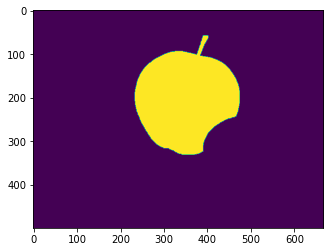

In [259]:
# Load the test masks, round the masks to get binary values 
maskfiles = glob.glob("testApples/*.png")
testMask = []
for myFile in maskfiles:
    im = Image.open(myFile)
    col, rows = im.size
    im = im.resize((round(col/downsize_num), round(rows/downsize_num)), Image.ANTIALIAS)
    im = np.array(im)/255
    im = np.round(np.array(im)[:,:,1])
    testMask.append(im)

f, (ax) = plt.subplots()
ax.imshow(testMask[0])

In [260]:
# Returns FPR, TPR, and the optimal ACC with the threshold
def ROC(mask, im):
    
    threshold_range = np.arange(0, 1, 0.05)
    
    FPR = np.zeros(len(threshold_range))
    TPR = np.zeros(len(threshold_range))
    bestACC = np.zeros(2)

    # All the 1 in mask
    Allp = np.sum(mask)

    # All the 0 in mask. Simply all points - Allp
    Alln = np.sum(mask.shape[0]*mask.shape[1] - Allp)

    for count, threshold in enumerate(threshold_range):
        decision = np.array(im)

        # apply threshold, change below threshold to 0 and others to 1
        result = np.where(decision <= threshold, 0, 1)

        # TP means it's 1, and decision says 1. Multiply so any 0 in either decision/mask will be 0.
        TP = np.sum(result * mask)

        # TN means it's 0, and decision says 0. Add 2 matrices and count the remaining 0. 
        add_TN = result + mask
        add_TN_0 = np.where(add_TN == 0, 1, 0)
        TN = np.sum(add_TN_0)

        # FP means it's 0, but decision says 1. Basically all 1 decisions - TP.
        FP = np.sum(result) - TP

        # Note again: FPR = FP/(FP+TN) = FP/negative, TPR = TP/(TP+FN) = TP/positive
        FPR[count] =  (FP/Alln)
        TPR[count] =  (TP/Allp)

        if (TP+TN)/(Allp+Alln) > bestACC[0]:
            bestACC = ((TP+TN)/(Allp+Alln), threshold)

    return FPR, TPR, bestACC


Best accuracy: 0.9826176911544228 at threshold: 0.5


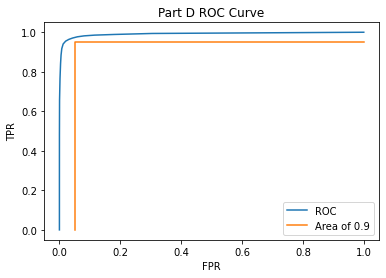

In [261]:
# Plot the ROC curve and evaluate the result

FPR, TPR, opACC = ROC(testMask[0], test_apple[2])
print("Best accuracy:", opACC[0], "at threshold:", opACC[1])

# Create a square with area 0.9 (roughly 0.95*0.95)
x = [0.05, 0.05, 1]
y = [0, 0.95, 0.95]

f, (ax) = plt.subplots()
plt.plot(FPR, TPR, label="ROC")
plt.plot(x, y, label="Area of 0.9")
ax.set_title('Part D ROC Curve')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.legend(loc="lower right")


## Comments 4
Reference research paper: 
* https://www.sciencedirect.com/science/article/pii/S1556086415306043
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2935260/

The area under the ROC curve (AUC) tells how good the model performs. According to research papers, AUC values between 0.8-0.9 are good and above 0.9 are excellent/outstanding. To be honest, our model performs the best on the test image that comes with a mask, probably because that image has a brown/white/orange background which really pops out the apple. After trying many different parameters, our model consistantly produce an AUC of above 0.9, which indicates that the performance is excellent. Furthermore, the acuracy is always higher than 96% (sometimes even over 99%), which again indicates the model is really good. 

# Part E: Self generate two apple images and evaluate the model's performance on them

The two apple images are from:
* https://unsplash.com/photos/crl5DLc5KbA
* https://unsplash.com/photos/d-2nGZwEL2M

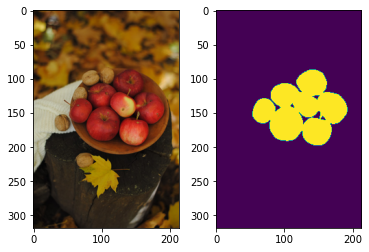

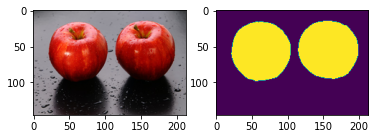

In [301]:
# Load and plot my apple images and masks

files = glob.glob("myapples/*.jpg")
myImgs = []
for myFile in files:
    im = Image.open(myFile)
    col, rows = im.size
    im = im.resize((round(col/downsize_num), round(rows/downsize_num)), Image.ANTIALIAS)
    im = np.array(im)/255
    myImgs.append(im)

maskfiles = glob.glob("myapples/*.png")
myMask = []
for myFile in maskfiles:
    im = Image.open(myFile)
    col, rows = im.size
    im = im.resize((round(col/downsize_num), round(rows/downsize_num)), Image.ANTIALIAS)
    im = np.array(im)/255
    im = np.round(np.array(im)[:,:,1])
    myMask.append(im)

for i in range(len(myImgs)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(myImgs[i])
    ax2.imshow(myMask[i])

dealing image  0
dealing image  1


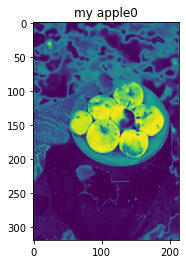

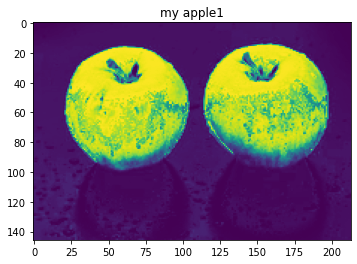

In [295]:
# Calculate the prior of my apples 

my_apple = eval_apple(myImgs, prior_apple)

for i in range(len(my_apple)):
    f, (ax) = plt.subplots()
    ax.imshow(my_apple[i])
    title = 'my apple '  + str(i)
    ax.set_title(title)

Best accuracy: 0.9753189986312861 at threshold: 0.6000000000000001


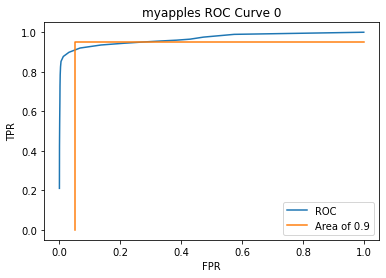

Best accuracy: 0.9881985979805775 at threshold: 0.15000000000000002


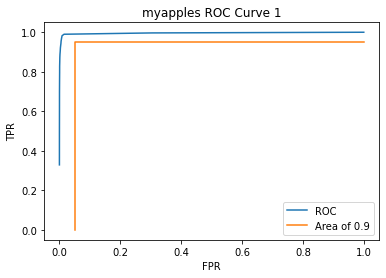

In [304]:
# Evaluate the performance
for i in range(len(my_apple)):
    myFPR, myTPR, myopACC = ROC(myMask[i], my_apple[i])
    print("Best accuracy:", myopACC[0], "at threshold:", myopACC[1])

    # Create a square with area 0.9 (roughly 0.95*0.95)
    x = [0.05, 0.05, 1]
    y = [0, 0.95, 0.95]

    f, (ax) = plt.subplots()
    plt.plot(myFPR, myTPR, label="ROC")
    plt.plot(x, y, label="Area of 0.9")
    title = 'myapples ROC Curve '  + str(i)
    ax.set_title(title)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    plt.legend(loc="lower right")
    plt.pause(0.3)

## Comments 5
* General: From our training we know that our model is good at telling red and green colors are related to apples. If the apple has the following, it will be quite hard for the model to tell if it is an apple: 
1. dark shadows 
2. very bright light spots 
3. unriped apples that are white or very light green
* myapples ROC Curve 0: The result of this image is the worst. I choose this image on purpose because the backgroud is full of brown-red colors so the model should have a hard time dealing with it. However, the brown-red background is still not as red as the apples, so with a threshold of 0.6, the model is still capable of predicting apples at over 97% accuracy. Also, the AUC is above 0.9, so the result is still outstanding.
* myapples ROC Curve 1: This image is optimal for the model. Only the apples are in red-green colors so the background is totally seperated from the apples. We can see that the best accuracy happens at threshold = 0.15, and this means there is almost zero gray area in this image. So if the model "think" this point might belong to an apple, it is probabiliy true (as in previous case that point might belong to green leafs). The possible miss-leading parts in this image is the white light spots and the dark shadows, which is nearly impossible to 100% avoid in any image.
* Final thoughts: The coursework tells us to make good ground-truth masks, but I don't think that makes a big difference. The images themselves might contain similar color backgrounds or have the issues in the 3 bullet points. A good ground-truth mask simply makes the edge points more accurate, but any problem mentioned above still can not be removed. 

# Part F: We should be using three separate sets of files

Obviously, a training set is used to train the model, and a test set is used to evaluate how well our model perform on unknown data. We evaluate the model using unknown data instead of training set to avoid overfitting. Overfitting is the case that the model strictly fit to a fixed set of data instead of finding out a reasonable data pattern. Thus, the model performs worse on any other dataset instead of the original training set. 

Above is the reason of using training and test set. Now we need to avoid the model to overfit on the training set, therefore we introduce a validation set. After each training epochs, we can validate whether the model is overfitting by evaluating the model with validation set. If the training error is way higher than the validation error, it is possible that the model starts to overfit and we should change some parameters. Note that a validaiton set is different from a test set, as any data appears in the training process has a possibility of overfitting, so the test set should be totally unknown during training.   